In [1]:
batch_size = 4096
STROKE_COUNT = 196
TRAIN_SAMPLES = 750
VALID_SAMPLES = 75
TEST_SAMPLES = 50

In [2]:
%matplotlib inline
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from keras.metrics import top_k_categorical_accuracy
def top_3_accuracy(x,y): return top_k_categorical_accuracy(x,y, 3)
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from glob import glob
import gc
gc.enable()

In [3]:
def get_available_gpus():
    from tensorflow.python.client import device_lib
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
base_dir = os.path.join('..', 'input')
test_path = os.path.join(base_dir, 'test_simplified.csv')

In [4]:
from ast import literal_eval
ALL_TRAIN_PATHS = glob(os.path.join('train_simplified', '*.csv'))
COL_NAMES = ['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word']

def _stack_it(raw_strokes):
    """preprocess the string and make
    a standard Nx3 stroke vector"""
    stroke_vec = literal_eval(raw_strokes) # string->list
    # unwrap the list
    in_strokes = [(xi,yi,i)
     for i,(x,y) in enumerate(stroke_vec)
     for xi,yi in zip(x,y)]
    c_strokes = np.stack(in_strokes)
    # replace stroke id with 1 for continue, 2 for new
    c_strokes[:,2] = [1]+np.diff(c_strokes[:,2]).tolist()
    c_strokes[:,2] += 1 # since 0 is no stroke
    # pad the strokes with zeros
    return pad_sequences(c_strokes.swapaxes(0, 1),
                         maxlen=STROKE_COUNT,
                         padding='post').swapaxes(0, 1)
def read_batch(samples=5,
               start_row=0,
               max_rows = 1000):
    """
    load and process the csv files
    this function is horribly inefficient but simple
    """
    out_df_list = []
    for c_path in ALL_TRAIN_PATHS:
        c_df = pd.read_csv(c_path, nrows=max_rows, skiprows=start_row)
        c_df.columns=COL_NAMES
        out_df_list += [c_df.sample(samples)[['drawing', 'word']]]
    full_df = pd.concat(out_df_list)
    full_df['drawing'] = full_df['drawing'].\
        map(_stack_it)

    return full_df

In [5]:
train_args = dict(samples=TRAIN_SAMPLES,
                  start_row=0,
                  max_rows=int(TRAIN_SAMPLES*1.5))
valid_args = dict(samples=VALID_SAMPLES,
                  start_row=train_args['max_rows']+1,
                  max_rows=VALID_SAMPLES+25)
test_args = dict(samples=TEST_SAMPLES,
                 start_row=valid_args['max_rows']+train_args['max_rows']+1,
                 max_rows=TEST_SAMPLES+25)
train_df = read_batch(**train_args)
valid_df = read_batch(**valid_args)
test_df = read_batch(**test_args)
word_encoder = LabelEncoder()
word_encoder.fit(train_df['word'])
print('words', len(word_encoder.classes_), '=>', ', '.join([x for x in word_encoder.classes_]))

words 340 => The Eiffel Tower, The Great Wall of China, The Mona Lisa, airplane, alarm clock, ambulance, angel, animal migration, ant, anvil, apple, arm, asparagus, axe, backpack, banana, bandage, barn, baseball, baseball bat, basket, basketball, bat, bathtub, beach, bear, beard, bed, bee, belt, bench, bicycle, binoculars, bird, birthday cake, blackberry, blueberry, book, boomerang, bottlecap, bowtie, bracelet, brain, bread, bridge, broccoli, broom, bucket, bulldozer, bus, bush, butterfly, cactus, cake, calculator, calendar, camel, camera, camouflage, campfire, candle, cannon, canoe, car, carrot, castle, cat, ceiling fan, cell phone, cello, chair, chandelier, church, circle, clarinet, clock, cloud, coffee cup, compass, computer, cookie, cooler, couch, cow, crab, crayon, crocodile, crown, cruise ship, cup, diamond, dishwasher, diving board, dog, dolphin, donut, door, dragon, dresser, drill, drums, duck, dumbbell, ear, elbow, elephant, envelope, eraser, eye, eyeglasses, face, fan, feathe

In [6]:
def get_Xy(in_df):
    X = np.stack(in_df['drawing'], 0)
    y = to_categorical(word_encoder.transform(in_df['word'].values))
    return X, y
train_X, train_y = get_Xy(train_df)
valid_X, valid_y = get_Xy(valid_df)
test_X, test_y = get_Xy(test_df)
print(train_X[1])

[[121   0   2]
 [112  68   1]
 [119   0   2]
 [126  13   1]
 [134  58   1]
 [133  75   1]
 [111  65   2]
 [111  72   1]
 [102  85   1]
 [ 99 122   1]
 [ 14 154   1]
 [  4 161   1]
 [  0 171   1]
 [  9 176   1]
 [109 175   1]
 [108 203   1]
 [111 218   1]
 [ 91 226   1]
 [ 73 239   1]
 [126 241   1]
 [130 234   1]
 [133 217   2]
 [129 254   1]
 [132 240   2]
 [191 239   1]
 [171 224   1]
 [148 221   1]
 [149 217   2]
 [144 177   1]
 [145 174   2]
 [175 179   1]
 [239 181   1]
 [244 179   1]
 [245 172   1]
 [235 159   1]
 [216 149   1]
 [181 135   1]
 [138 123   1]
 [142 110   1]
 [140  85   1]
 [137  77   1]
 [128  69   1]
 [116  77   2]
 [116  79   1]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0 

In [7]:
print(train_X.shape)

(255000, 196, 3)


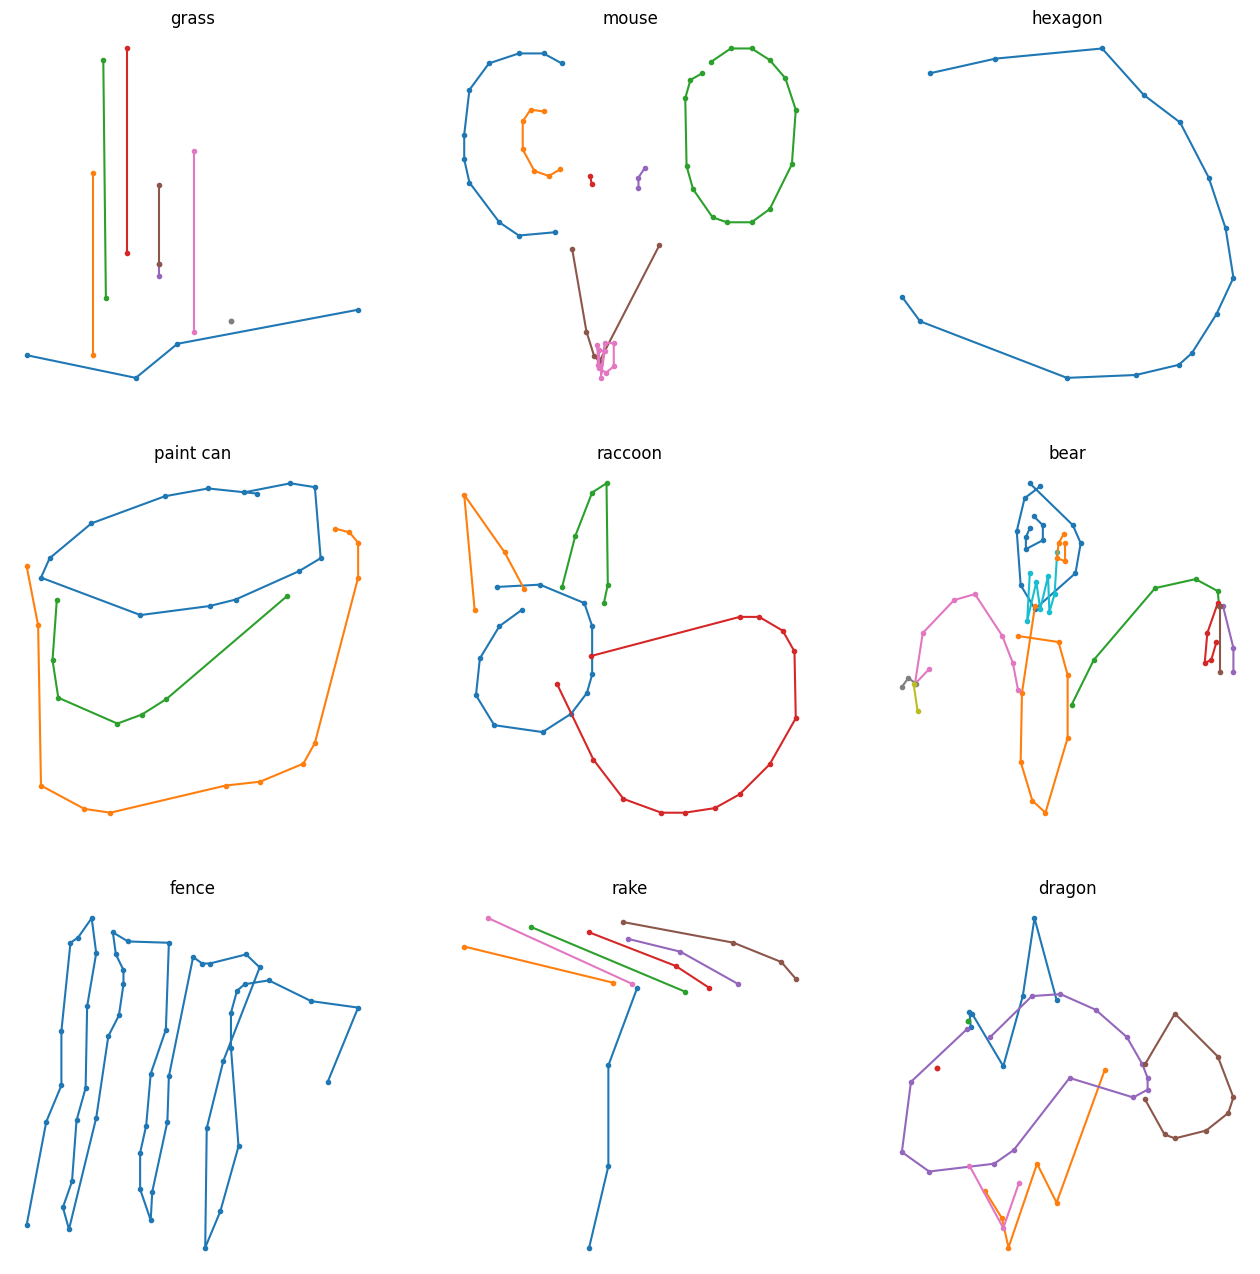

In [8]:
fig, m_axs = plt.subplots(3,3, figsize = (16, 16))
rand_idxs = np.random.choice(range(train_X.shape[0]), size = 9)
for c_id, c_ax in zip(rand_idxs, m_axs.flatten()):
    test_arr = train_X[c_id]
    test_arr = test_arr[test_arr[:,2]>0, :] # only keep valid points
    lab_idx = np.cumsum(test_arr[:,2]-1)
    for i in np.unique(lab_idx):
        c_ax.plot(test_arr[lab_idx==i,0],
                np.max(test_arr[:,1])-test_arr[lab_idx==i,1], '.-')
    c_ax.axis('off')
    c_ax.set_title(word_encoder.classes_[np.argmax(train_y[c_id])])

In [9]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv1D, LSTM, Dense, Dropout
if len(get_available_gpus())>0:
    # https://twitter.com/fchollet/status/918170264608817152?lang=en
    from keras.layers import CuDNNLSTM as LSTM # this one is about 3x faster on GPU instances

In [10]:
model = Sequential([
    BatchNormalization(input_shape = (None,)+train_X.shape[2:]),
# filter count and length are taken from the script https://github.com/tensorflow/models/blob/master/tutorials/rnn/quickdraw/train_model.py
    Conv1D(48, (5,)),
    Dropout(0.3),
    Conv1D(64, (5,)),
    Dropout(0.3),
    Conv1D(96, (3,)),
    Dropout(0.3),
    LSTM(128, return_sequences = True),
    Dropout(0.3),
    LSTM(128, return_sequences = False),
    Dropout(0.3),
    Dense(512),
    Dropout(0.3),
    Dense(len(word_encoder.classes_), activation = 'softmax')
])

In [11]:
model.compile(optimizer = 'adam',
                          loss = 'categorical_crossentropy',
                          metrics = ['categorical_accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, None, 3)          12        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, None, 48)          768       
                                                                 
 dropout (Dropout)           (None, None, 48)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, None, 64)          15424     
                                                                 
 dropout_1 (Dropout)         (None, None, 64)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, None, 96)          18528     
                                                        

In [12]:
epochs = 50

model.fit(train_X, train_y,
    validation_data = (valid_X, valid_y),
    epochs=epochs,
    verbose=1,
    batch_size=4096
)

# model.save('./models/model_rnn')

Epoch 1/50
63/63 [==============================] - 880s 14s/step - loss: 5.8298 - categorical_accuracy: 0.0032 - val_loss: 5.8250 - val_categorical_accuracy: 0.0036
Epoch 2/50
63/63 [==============================] - 852s 14s/step - loss: 5.8200 - categorical_accuracy: 0.0036 - val_loss: 5.7563 - val_categorical_accuracy: 0.0049
Epoch 3/50
63/63 [==============================] - 864s 14s/step - loss: 5.5862 - categorical_accuracy: 0.0086 - val_loss: 5.5462 - val_categorical_accuracy: 0.0109
Epoch 4/50
63/63 [==============================] - 877s 14s/step - loss: 5.4272 - categorical_accuracy: 0.0136 - val_loss: 5.3761 - val_categorical_accuracy: 0.0182
Epoch 5/50
63/63 [==============================] - 859s 14s/step - loss: 5.2738 - categorical_accuracy: 0.0200 - val_loss: 5.1576 - val_categorical_accuracy: 0.0276
Epoch 6/50
63/63 [==============================] - 849s 13s/step - loss: 5.1189 - categorical_accuracy: 0.0274 - val_loss: 5.0074 - val_categorical_accuracy: 0.0351
Epoc

In [14]:
# model = tf.keras.models.load_model("models/rnn.h5")
model.save('./models/rnn')
lstm_results = model.evaluate(test_X, test_y, verbose=1)
print(lstm_results[1])

INFO:tensorflow:Assets written to: ./models/rnn\assets


INFO:tensorflow:Assets written to: ./models/rnn\assets


532/532 [==============================] - 54s 98ms/step - loss: 1.9355 - categorical_accuracy: 0.5289
0.5289411544799805


1/1 [==============================] - 0s 31ms/step


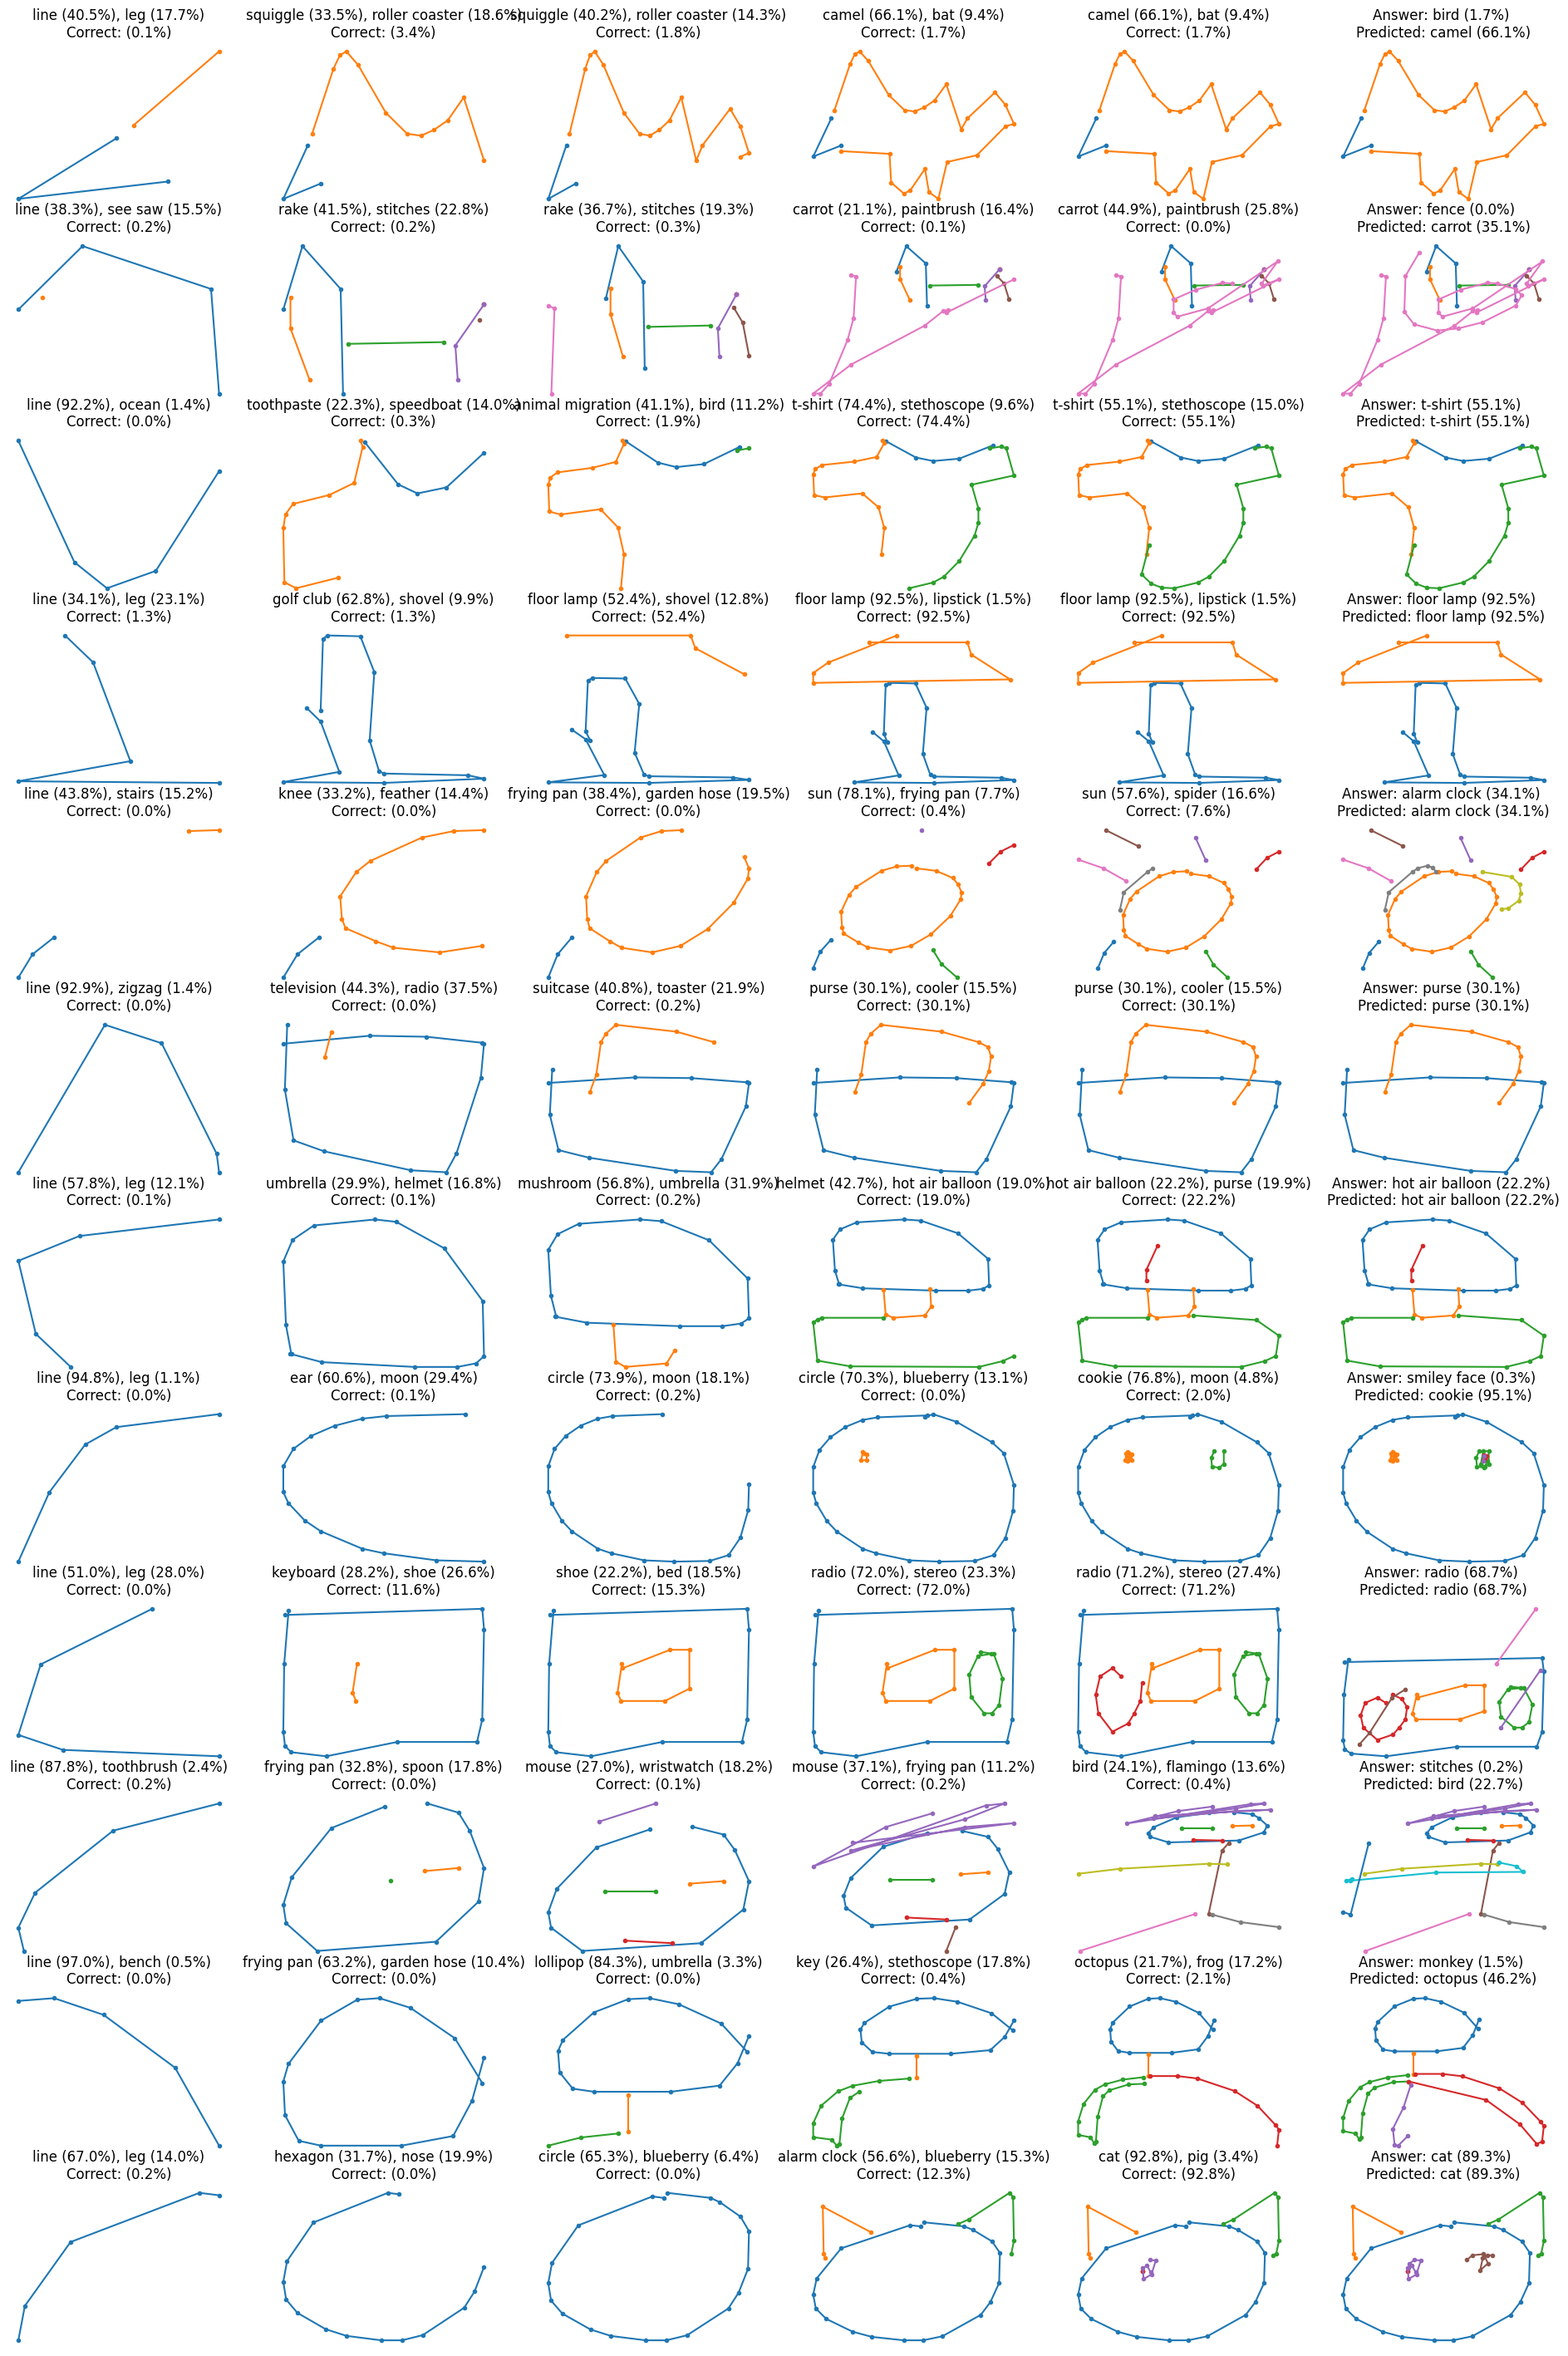

In [15]:
points_to_use = [5, 15, 20, 30, 40, 50]
points_to_user = [108]
samples = 12
word_dex = lambda x: word_encoder.classes_[x]
rand_idxs = np.random.choice(range(test_X.shape[0]), size = samples)
fig, m_axs = plt.subplots(len(rand_idxs), len(points_to_use), figsize = (24, samples/8*24))
for c_id, c_axs in zip(rand_idxs, m_axs):
    res_idx = np.argmax(test_y[c_id])
    goal_cat = word_encoder.classes_[res_idx]

    for pt_idx, (pts, c_ax) in enumerate(zip(points_to_use, c_axs)):
        test_arr = test_X[c_id, :].copy()
        test_arr[pts:] = 0 # short sequences make CudnnLSTM crash, ugh
        stroke_pred = model.predict(np.expand_dims(test_arr,0))[0]
        top_10_idx = np.argsort(-1*stroke_pred)[:10]
        top_10_sum = np.sum(stroke_pred[top_10_idx])

        test_arr = test_arr[test_arr[:,2]>0, :] # only keep valid points
        lab_idx = np.cumsum(test_arr[:,2]-1)
        for i in np.unique(lab_idx):
            c_ax.plot(test_arr[lab_idx==i,0],
                    np.max(test_arr[:,1])-test_arr[lab_idx==i,1], # flip y
                      '.-')
        c_ax.axis('off')
        if pt_idx == (len(points_to_use)-1):
            c_ax.set_title('Answer: %s (%2.1f%%) \nPredicted: %s (%2.1f%%)' % (goal_cat, 100*stroke_pred[res_idx]/top_10_sum, word_dex(top_10_idx[0]), 100*stroke_pred[top_10_idx[0]]/top_10_sum))
        else:
            c_ax.set_title('%s (%2.1f%%), %s (%2.1f%%)\nCorrect: (%2.1f%%)' % (word_dex(top_10_idx[0]), 100*stroke_pred[top_10_idx[0]]/top_10_sum,
                                                                 word_dex(top_10_idx[1]), 100*stroke_pred[top_10_idx[1]]/top_10_sum,
                                                                 100*stroke_pred[res_idx]/top_10_sum))

In [16]:
from tensorflow.keras import models
test = models.load_model("models/rnn")

In [17]:
lstm_results = test.evaluate(test_X, test_y, verbose=1)
print(lstm_results[1])

532/532 [==============================] - 52s 97ms/step - loss: 1.9355 - categorical_accuracy: 0.5289
0.5289411544799805
